# 0. Разобраться с minimap2

```
$ minimap2 -a --MD --cs=MD -x map-pb data/reference.fasta data/pacbio_40x.fq.gz > pacbio.sam
[M::mm_idx_gen::0.151*0.90] collected minimizers
[M::mm_idx_gen::0.176*1.17] sorted minimizers
[M::main::0.176*1.17] loaded/built the index for 1 target sequence(s)
[M::mm_mapopt_update::0.192*1.16] mid_occ = 11
[M::mm_idx_stat] kmer size: 19; skip: 10; is_hpc: 1; #seq: 1
[M::mm_idx_stat::0.201*1.15] distinct minimizers: 606828 (98.95% are singletons); average occurrences: 1.024; average spacing: 7.468
[M::worker_pipeline::58.550*2.79] mapped 41447 sequences
[M::main] Version: 2.16-r922
[M::main] CMD: minimap2 -ax map-pb data/reference.fasta data/pacbio_40x.fq.gz
[M::main] Real time: 58.571 sec; CPU: 163.574 sec; Peak RSS: 1.603 GB

$ minimap2 -a --MD --cs=MD -x map-ont data/reference.fasta data/ONT_2D.fastq.gz > ont.sam
[M::mm_idx_gen::0.160*1.02] collected minimizers
[M::mm_idx_gen::0.200*1.40] sorted minimizers
[M::main::0.200*1.40] loaded/built the index for 1 target sequence(s)
[M::mm_mapopt_update::0.218*1.36] mid_occ = 11
[M::mm_idx_stat] kmer size: 15; skip: 10; is_hpc: 0; #seq: 1
[M::mm_idx_stat::0.231*1.34] distinct minimizers: 838533 (98.18% are singletons); average occurrences: 1.034; average spacing: 5.352
[M::worker_pipeline::22.272*2.50] mapped 30810 sequences
[M::main] Version: 2.16-r922
[M::main] CMD: minimap2 -ax map-ont data/reference.fasta data/ONT_2D.fastq.gz
[M::main] Real time: 22.287 sec; CPU: 55.640 sec; Peak RSS: 0.917 GB

$ samtools flagstat ont.sam
32103 + 0 in total (QC-passed reads + QC-failed reads)
1072 + 0 secondary
221 + 0 supplementary
0 + 0 duplicates
29565 + 0 mapped (92.09% : N/A)
0 + 0 paired in sequencing
0 + 0 read1
0 + 0 read2
0 + 0 properly paired (N/A : N/A)
0 + 0 with itself and mate mapped
0 + 0 singletons (N/A : N/A)
0 + 0 with mate mapped to a different chr
0 + 0 with mate mapped to a different chr (mapQ>=5)

$ samtools flagstat pacbio.sam
52081 + 0 in total (QC-passed reads + QC-failed reads)
1736 + 0 secondary
8898 + 0 supplementary
0 + 0 duplicates
51199 + 0 mapped (98.31% : N/A)
0 + 0 paired in sequencing
0 + 0 read1
0 + 0 read2
0 + 0 properly paired (N/A : N/A)
0 + 0 with itself and mate mapped
0 + 0 singletons (N/A : N/A)
0 + 0 with mate mapped to a different chr
0 + 0 with mate mapped to a different chr (mapQ>=5)

$ samtools sort -o ont.bam ont.sam
$ samtools sort -o pacbio.bam pacbio.sam

$ samtools index ont.bam
$ samtools index pacbio.bam
```

# 1. Статистики ридов PacBio и Oxford Nanopores.
## Покрытие

In [12]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
import os
import pysam
from itertools import zip_longest, islice
import pysamstats
from collections import Counter
from tqdm import tqdm
from Bio import SeqIO
import gzip

def grouper(iterable, n, fillvalue=None):
    "Collect data into fixed-length chunks or blocks"
    # grouper('ABCDEFG', 3, 'x') --> ABC DEF Gxx"
    args = [iter(iterable)] * n
    return zip_longest(*args, fillvalue=fillvalue)

Avg coverage 28.011291166020673
Genome covered 100.0%


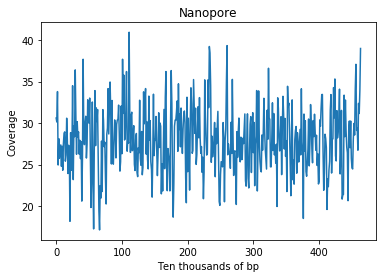

In [7]:
coverages = []
samfile = pysam.AlignmentFile("work/ont.bam", "rb")
samfilelength = samfile.lengths[0]
nonzerobp = 0
tlen = []
for pileupcolumn in grouper(samfile.pileup(), 10000):
    bucket = [x.nsegments for x in pileupcolumn if x != None]
    nonzerobp += np.count_nonzero(bucket)
    avg_coverage = np.mean(bucket)
    coverages.append(avg_coverage)
samfile.close()

plt.plot(list(range(0, len(coverages))), coverages)
plt.title("Nanopore")
plt.ylabel("Coverage")
plt.xlabel("Ten thousands of bp")
print(f"Avg coverage {np.mean(coverages)}")
print(f"Genome covered {nonzerobp / samfilelength * 100}%")

Avg coverage 40.12294057571505
Genome covered 100.0%


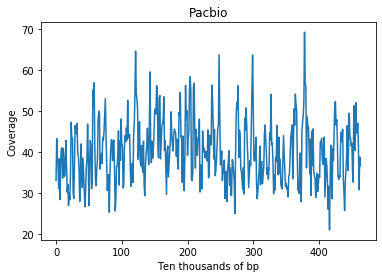

In [8]:
 coverages = []
samfile = pysam.AlignmentFile("work/pacbio.bam", "rb")
samfilelength = samfile.lengths[0]
nonzerobp = 0
tlen = []
for pileupcolumn in grouper(samfile.pileup(), 10000):
    bucket = [x.nsegments for x in pileupcolumn if x != None]
    nonzerobp += np.count_nonzero(bucket)
    avg_coverage = np.mean(bucket)
    coverages.append(avg_coverage)
samfile.close()

plt.plot(list(range(0, len(coverages))), coverages)
plt.title("Pacbio")
plt.ylabel("Coverage")
plt.xlabel("Ten thousands of bp")
print(f"Avg coverage {np.mean(coverages)}")
print(f"Genome covered {nonzerobp / samfilelength * 100}%")

#### Средний процент ошибок в ридах

```
$ awk '/NM/ {split($12,a,":"); k = a[3]/length($10); if (k <= 1) {c++; s += k}} END {print s/c*100. "%"}' ont.sam
8.03838%

$ awk '/NM/ {split($12,a,":"); k = a[3]/length($10); if (k <= 1) {c++; s += k}} END {print s/c*100. "%"}' pacbio.sam
13.1667%
```

## Распределение типов замен


In [30]:
mat = Counter()

with pysam.AlignmentFile('work/pacbio.bam', 'rb') as file:
    for read in tqdm(file):
        try:
            aligned_pairs = read.get_aligned_pairs(with_seq=True)
        except:
            continue

        for p in aligned_pairs:
            if (p[0] is None) or (p[2] is None) or (p[2] == 'N'):
                continue
                
            ref = p[2].upper()
            read_nucl = read.seq[p[0]].upper()
            
            if read_nucl == 'N':
                continue

            if read_nucl != ref:
                mat[(ref, read_nucl)] += 1

for n, i in enumerate('ACTG'):
    print(f" {i:>{8}}", end="")
print()
for i in 'ACTG':
    print(f"{i}", end=" ")
    for j in 'ACTG': 
        print(f"{mat[(i,j)]:>8}", end=" ")
    print()

52081it [03:43, 233.12it/s]

        A        C        T        G
A        0   357476   289389   309921 
C   464039        0   327274   418981 
T   289533   311896        0   362955 
G   327302   420393   456051        0 


In [20]:
mat = Counter()

with pysam.AlignmentFile('work/ont.bam', 'rb') as file:
    for read in tqdm(file):
        try:
            aligned_pairs = read.get_aligned_pairs(with_seq=True)
        except:
            continue

        for p in aligned_pairs:
            if (p[0] is None) or (p[2] is None) or (p[2] == 'N'):
                continue
                
            ref = p[2].upper()
            read_nucl = read.seq[p[0]].upper()
            
            if read_nucl == 'N':
                continue

            if read_nucl != ref:
                mat[(ref, read_nucl)] += 1

for n, i in enumerate('ACTG'):
    print(f" {i:>{8}}", end="")
print()
for i in 'ACTG':
    print(f"{i}", end=" ")
    for j in 'ACTG': 
        print(f"{mat[(i,j)]:>8}", end=" ")
    print()

32103it [02:11, 243.65it/s]

        A        C        T        G
A        0   112963   105373   368487 
C   137046        0   340675    85027 
T   107765   372780        0   111447 
G   319761    91353   126487        0 


## Распределение длин инделов


Mean insert length = 1.5554632739328063
Mean del length = 1.2000728526775055
Mean indel length = 2.2570165175389687


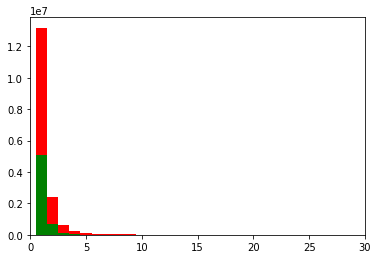

In [28]:
data = pd.read_csv("work/pacbio.indels", sep=' ', header=None).values
p1 = plt.bar(data[:,0], data[:,2], 1, color='g')
p2 = plt.bar(data[:,0], data[:,1], 1, bottom=data[:,2], color='r')

print(f"Mean insert length = {np.sum(data[:,1]*data[:,0])/np.sum(data[:,1])}")
print(f"Mean del length = {np.sum(data[:,2]*data[:,0])/np.sum(data[:,2])}")
print(f"Mean indel length = {np.sum((data[:,0] + data[:,1])*data[:,0])/np.sum(data[:,0] + data[:,1])}")
plt.xlim(0,30)
plt.show()

Mean insert length = 1.7270292923341144
Mean del length = 1.8844170026756222
Mean indel length = 4.90949152618144


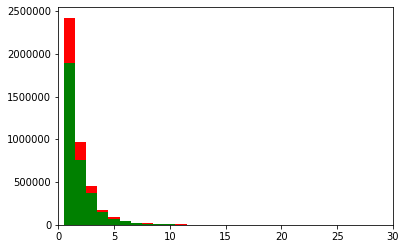

In [29]:
data = pd.read_csv("work/ont.indels", sep=' ', header=None).values
p1 = plt.bar(data[:,0], data[:,2], 1, color='g')
p2 = plt.bar(data[:,0], data[:,1], 1, bottom=data[:,2], color='r')

print(f"Mean insert length = {np.sum(data[:,1]*data[:,0])/np.sum(data[:,1])}")
print(f"Mean del length = {np.sum(data[:,2]*data[:,0])/np.sum(data[:,2])}")
print(f"Mean indel length = {np.sum((data[:,0] + data[:,1])*data[:,0])/np.sum(data[:,0] + data[:,1])}")
plt.xlim(0,30)
plt.show()